In [118]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('notebook')

from glob import glob
from os import path
from multiprocessing import Pool

import vg

from collections import defaultdict

import sqlite3

import sys
sys.path.insert(1, '../src/')
from mythicwind.gps import *
from mythicwind.csv_io import *

data_dir = '../data'
results_dir = '../results'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
blade_installations = dict()

install_db = sqlite3.connect(path.join(data_dir, 'installation-times.sqlite'))
install_db_cur = install_db.cursor()

for (turbine_name, blade_number, start_epoch, end_epoch) in install_db_cur.execute('SELECT turbine_name, blade_number, blade_installation_start_epoch, blade_installation_end_epoch FROM blade_installation_success WHERE turbine_id < 17'):
    start = pd.to_datetime(start_epoch, unit='s', utc=True)
    end = pd.to_datetime(end_epoch, unit='s', utc=True)
    delta_t = end-start
    # print(turbine_name, blade_number, start, end, delta_t)
    blade_installations[f'{turbine_name}_b-{blade_number}'] = {'start' : start,
                                                               'end'   : end,
                                                               'deltaT': delta_t,
                                                              }

In [120]:
available_wind = dict()
available_waves = dict()

wind = list()
waves = list()

for f in glob('../data/environment/wind/lidar/*.csv'):
    date = f.split('_')[-1].split('.')[0]
    available_wind[date] = f
    
for f in glob('../data/environment/waves/wmb-sued/*.csv'):
    date = f.split('_')[-1].split('.')[0]
    available_waves[date] = f


for turbine_id, times in blade_installations.items():
    installation_date_start = f'{times["start"].year}-{times["start"].month:02d}-{times["start"].day:02d}'
    installation_date_end = f'{times["end"].year}-{times["end"].month:02d}-{times["end"].day:02d}'
    
    if installation_date_start in available_waves:
        #print(f'adding {installation_date_start} to available waves: reading in file {available_waves[installation_date_start]}')
        waves.append(read_frame(available_waves[installation_date_start]))
    if installation_date_start in available_wind:
        wind.append(read_frame(available_wind[installation_date_start]))

    if installation_date_end > installation_date_start:
        if installation_date_end in available_waves:
            waves.append(read_frame(available_waves[installation_date_end]))
            
        if installation_date_end in available_wind:
            wind.append(read_frame(available_wind[installation_date_end]))

waves_df = pd.concat(waves)
wind_df = pd.concat(wind)

waves_df.sort_index(inplace=True)
wind_df.sort_index(inplace=True)

del(waves, wind, available_waves, available_wind)

<IPython.core.display.Javascript object>


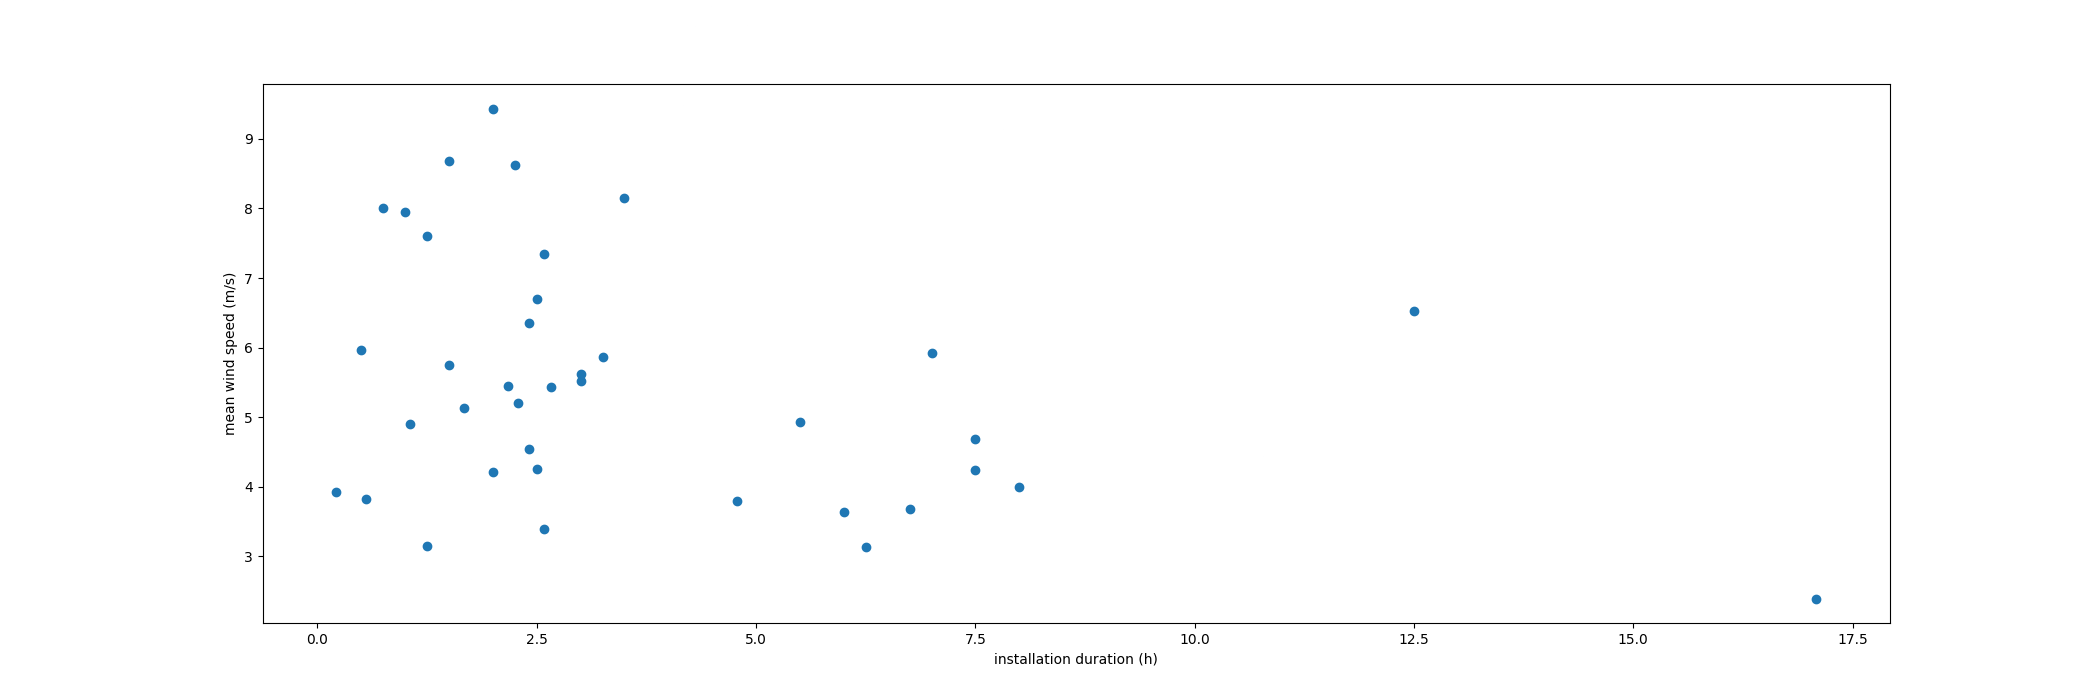

In [131]:
plt.figure()
for turbine_id, blade_installation in blade_installations.items():
    wind_mean = wind_df.wind_speed_3[blade_installation['start']:blade_installation['end']].mean()
    plt.scatter(blade_installation['deltaT'].total_seconds()/3600, wind_mean, color='tab:blue')
plt.xlabel('installation duration (h)')
plt.ylabel('mean wind speed (m/s)')
plt.savefig('../results/installation-times/wind-speed-mean_installation-times.png', dpi=150)

<IPython.core.display.Javascript object>


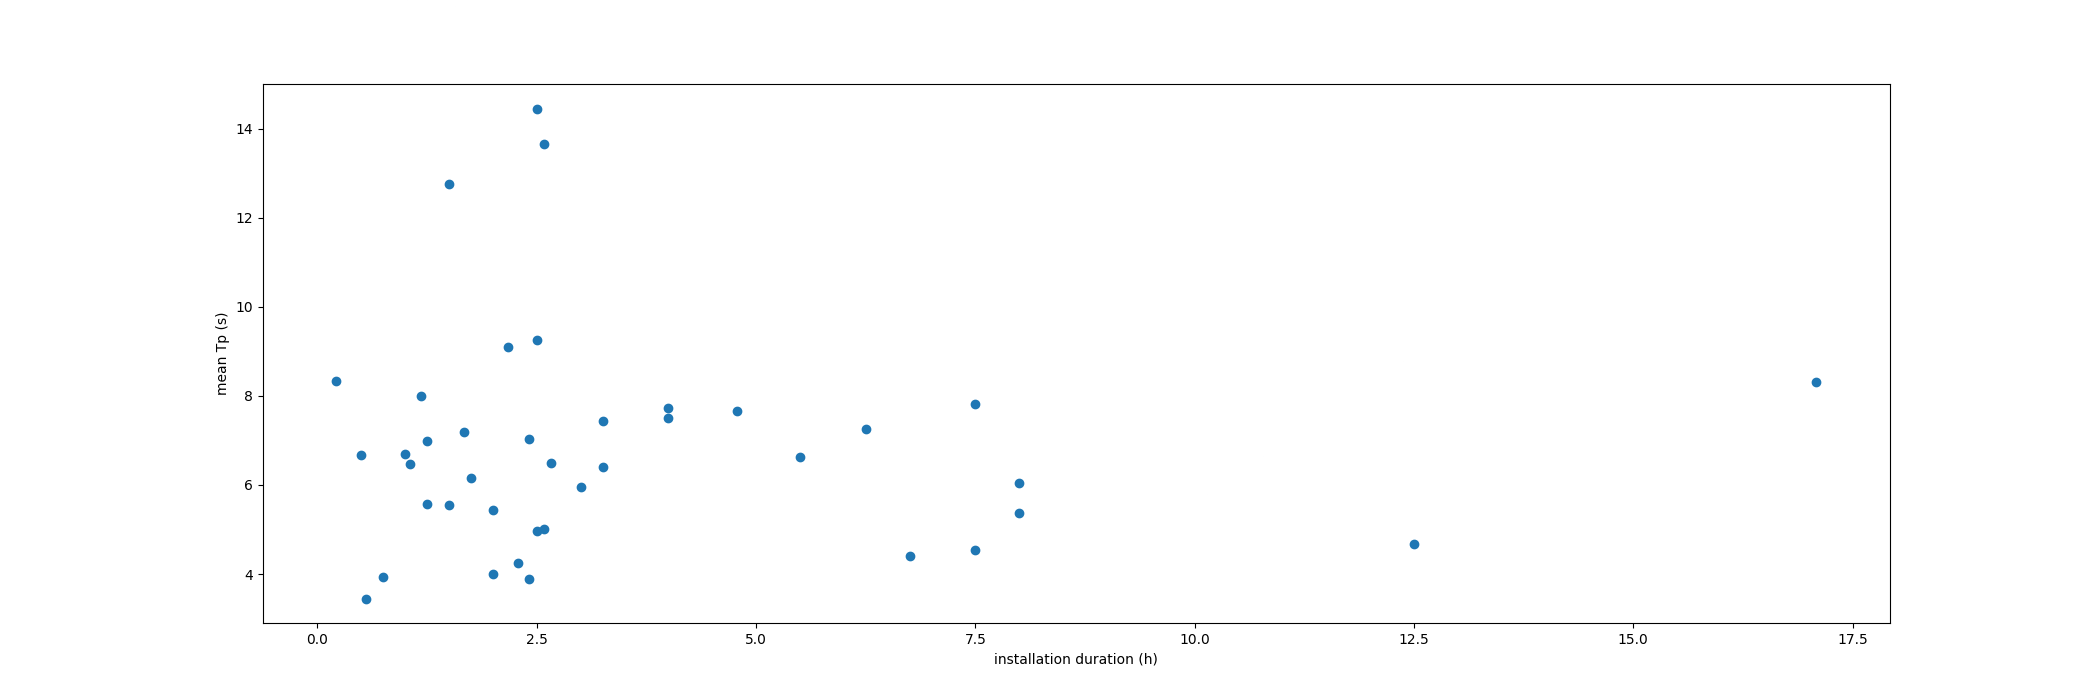

In [132]:
plt.figure()
for turbine_id, blade_installation in blade_installations.items():
    waves_tp = waves_df.Tp[blade_installation['start']:blade_installation['end']].mean()
    plt.scatter(blade_installation['deltaT'].total_seconds()/3600, waves_tp, color='tab:blue')
plt.xlabel('installation duration (h)')
plt.ylabel('mean Tp (s)')
plt.savefig('../results/installation-times/waves-tp-mean_installation-times.png', dpi=150)

<IPython.core.display.Javascript object>


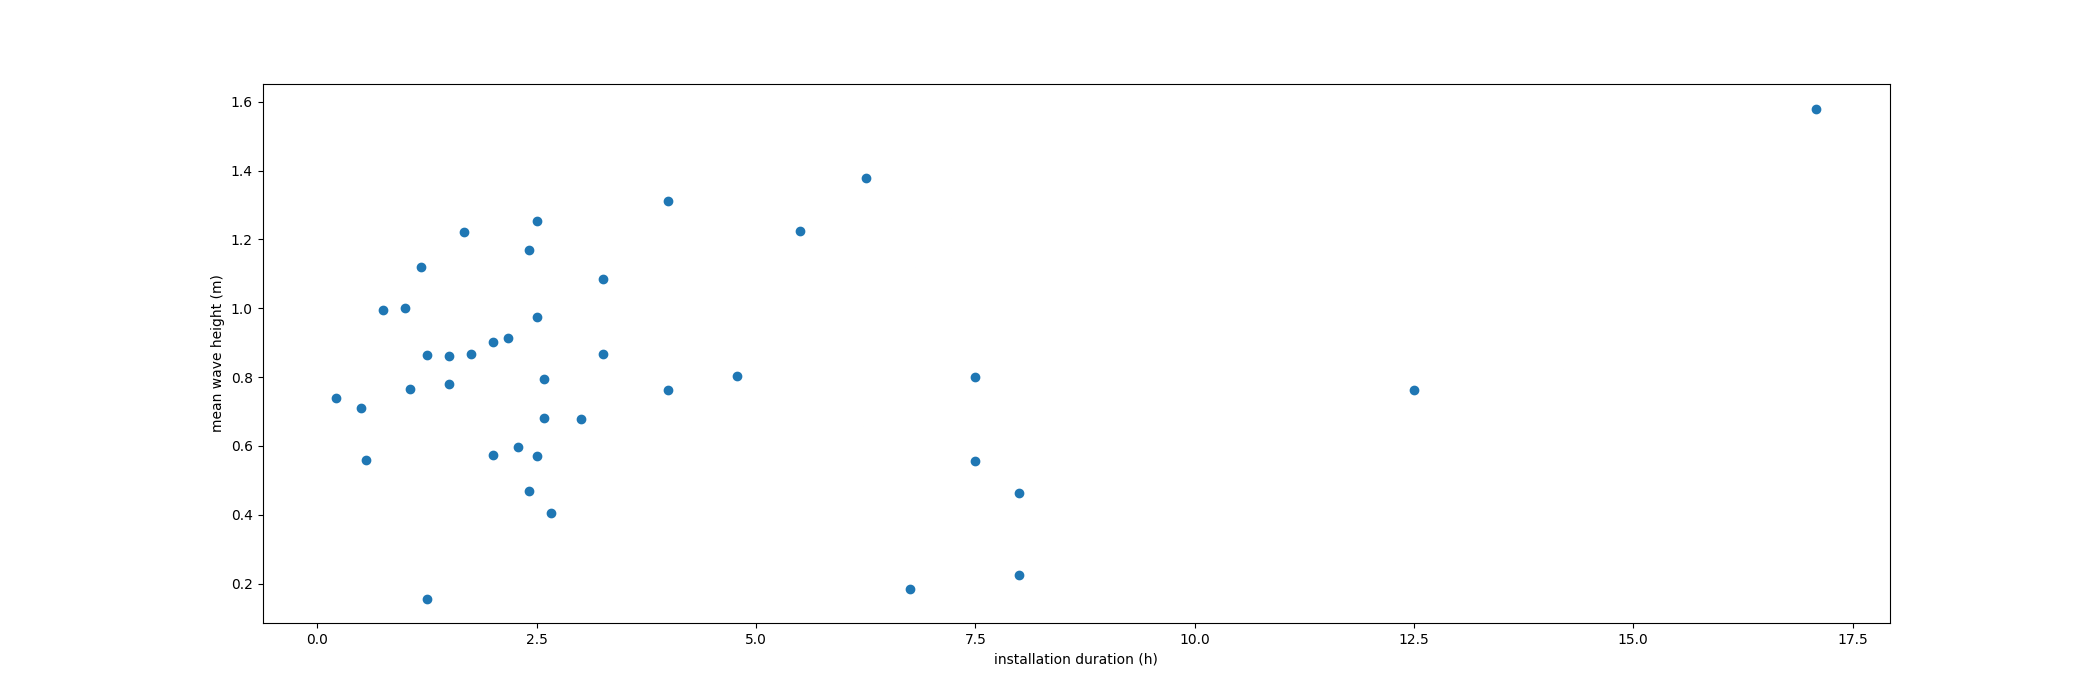

In [133]:
plt.figure()
for turbine_id, blade_installation in blade_installations.items():
    waves_mean = waves_df.Hm0[blade_installation['start']:blade_installation['end']].mean()
    plt.scatter(blade_installation['deltaT'].total_seconds()/3600, waves_mean, color='tab:blue')
plt.xlabel('installation duration (h)')
plt.ylabel('mean wave height (m)')
plt.savefig('../results/installation-times/waves-hm0-mean_installation-times.png', dpi=150)

<IPython.core.display.Javascript object>


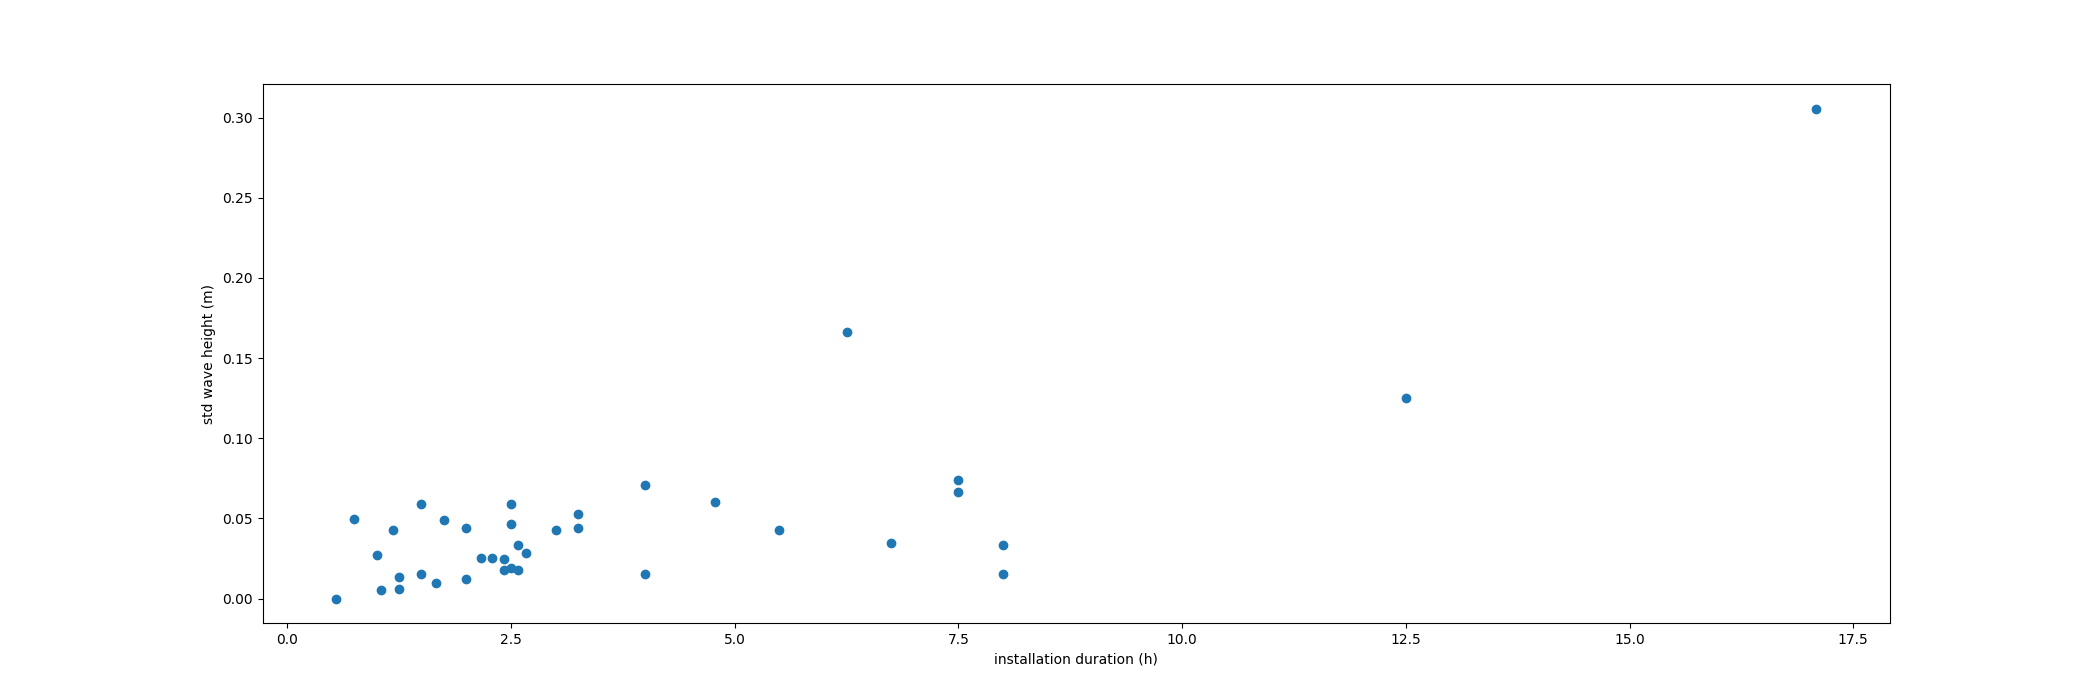

In [134]:
plt.figure()
for turbine_id, blade_installation in blade_installations.items():
    waves_std = waves_df.Hm0[blade_installation['start']:blade_installation['end']].std()
    plt.scatter(blade_installation['deltaT'].total_seconds()/3600, waves_std, color='tab:blue')
plt.xlabel('installation duration (h)')
plt.ylabel('std wave height (m)')
plt.savefig('../results/installation-times/waves-hm0-std_installation-times.png', dpi=150)

<IPython.core.display.Javascript object>


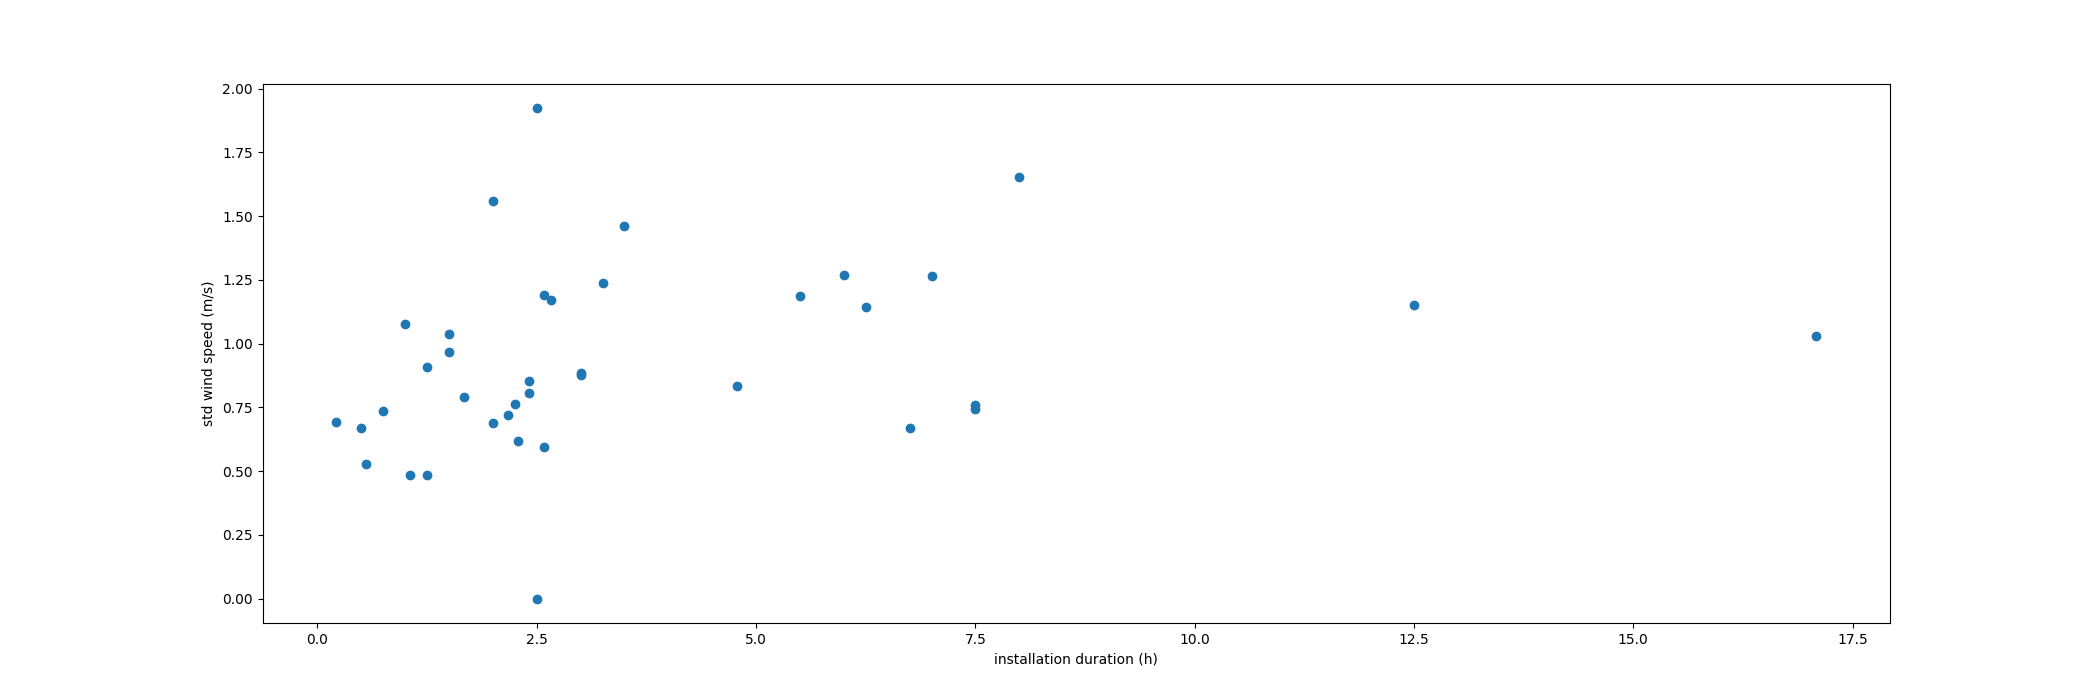

In [135]:
plt.figure()
for turbine_id, blade_installation in blade_installations.items():
    wind_std = wind_df.wind_speed_3[blade_installation['start']:blade_installation['end']].std()
    plt.scatter(blade_installation['deltaT'].total_seconds()/3600, wind_std, color='tab:blue')
plt.xlabel('installation duration (h)')
plt.ylabel('std wind speed (m/s)')
plt.savefig('../results/installation-times/wind-speed-std_installation-times.png', dpi=150)